In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
DATA_DIR = '/data/workspace_files/BTC and ETH Price Data/'

### BTC and ETH Price Data

This notebook includes our initial dataset compilation and EDA for the Bitcoin (BTC) and Ether (ETH) price data obtained. All data for this notbook is included in the `DATA_DIR` folder, and was obtained from the following sources:

1. Gemini Exchange BTC and ETH minute level data: https://www.cryptodatadownload.com/data/gemini/ 
2. BTC daily data: https://www.coindesk.com/price/bitcoin
3. ETH daily data: https://www.coindesk.com/price/ethereum
4. Supplemental BTC minute level data: https://www.kaggle.com/mczielinski/bitcoin-historical-data

The supplemental BTC minute level data was used to fill in certain missing values from the Gemini minute level data, primarily around the November 2018 crash. We begin by loading all the data into the notebook.

In [3]:
btc_daily = pd.read_csv(os.path.join(DATA_DIR, 'BTC_USD_2013-09-30_2021-08-09-CoinDesk.csv'),
                  parse_dates=['Date'], index_col='Date')
btc_daily = btc_daily.resample('D').asfreq()
btc_daily.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-09-30,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-01,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-02,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-03,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-04,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
btc_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2871 entries, 2013-09-30 to 2021-08-09
Freq: D
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2871 non-null   object 
 1   Closing Price (USD)  2871 non-null   float64
 2   24h Open (USD)       2871 non-null   float64
 3   24h High (USD)       2871 non-null   float64
 4   24h Low (USD)        2871 non-null   float64
dtypes: float64(4), object(1)
memory usage: 134.6+ KB


In [5]:
eth_daily = pd.read_csv(os.path.join(DATA_DIR, 'ETH_USD_2015-08-08_2021-08-09-CoinDesk.csv'),
                  parse_dates=['Date'], index_col='Date')
eth_daily = eth_daily.resample('D').asfreq()
eth_daily.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2015-08-08,ETH,0.909046,1.749289,1.916540,0.794497
2015-08-09,ETH,0.692321,0.909046,0.909046,0.692321
2015-08-10,ETH,0.668067,0.692321,0.692321,0.654331
2015-08-11,ETH,0.850151,0.668067,1.148621,0.668067
2015-08-12,ETH,1.266023,0.850151,1.266023,0.850151


In [6]:
eth_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194 entries, 2015-08-08 to 2021-08-09
Freq: D
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2194 non-null   object 
 1   Closing Price (USD)  2194 non-null   float64
 2   24h Open (USD)       2194 non-null   float64
 3   24h High (USD)       2194 non-null   float64
 4   24h Low (USD)        2194 non-null   float64
dtypes: float64(4), object(1)
memory usage: 102.8+ KB


In [7]:
def load_multiple(files, **kwargs):
    """Helper function to load and concatenate multiple 
    files into a single DataFrame.
    """
    dfs = []
    for file in files:
        df = pd.read_csv(file, **kwargs)
        dfs.append(df)

    return pd.concat(dfs, axis=0).sort_index()

In [8]:
btc_files = [
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2015_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2016_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2017_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2018_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2019_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2020_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_BTCUSD_2021_1min.csv')
]

eth_files = [
    os.path.join(DATA_DIR, 'gemini_ETHUSD_2016_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_ETHUSD_2017_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_ETHUSD_2018_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_ETHUSD_2019_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_ETHUSD_2020_1min.csv'),
    os.path.join(DATA_DIR, 'gemini_ETHUSD_2021_1min.csv'),
]

In [9]:
btc_min = load_multiple(btc_files, skiprows=1, 
                        parse_dates=['Date'], index_col='Date')
btc_min = btc_min.resample('1T').asfreq()
btc_min.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2015-10-08 13:40:00,1.444312e+09,BTCUSD,0.00,242.50,0.00,242.50,0.050000
2015-10-08 13:41:00,1.444312e+09,BTCUSD,242.50,242.95,242.50,242.95,0.001000
2015-10-08 13:42:00,1.444312e+09,BTCUSD,242.95,242.95,242.95,242.95,0.000000
2015-10-08 13:43:00,1.444312e+09,BTCUSD,242.95,242.96,242.95,242.96,0.010000
2015-10-08 13:44:00,1.444312e+09,BTCUSD,242.96,242.96,242.96,242.96,0.033491


In [10]:
btc_min.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3070705 entries, 2015-10-08 13:40:00 to 2021-08-10 00:04:00
Freq: T
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unix Timestamp  2966010 non-null  float64
 1   Symbol          2966010 non-null  object 
 2   Open            2966010 non-null  float64
 3   High            2966010 non-null  float64
 4   Low             2966010 non-null  float64
 5   Close           2966010 non-null  float64
 6   Volume          2966010 non-null  float64
dtypes: float64(6), object(1)
memory usage: 187.4+ MB


In [11]:
eth_min = load_multiple(eth_files, skiprows=1, 
                        parse_dates=['Date'], index_col='Date')
eth_min = eth_min.resample('1T').asfreq()
eth_min.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2016-05-09 13:32:00,1.462801e+09,ETHUSD,0.0,12.0,0.0,12.0,4.156276
2016-05-09 13:33:00,1.462801e+09,ETHUSD,12.0,12.0,10.0,10.0,43.497506
2016-05-09 13:34:00,1.462801e+09,ETHUSD,10.0,10.0,10.0,10.0,8.000000
2016-05-09 13:35:00,1.462801e+09,ETHUSD,10.0,10.0,10.0,10.0,60.000000
2016-05-09 13:36:00,1.462801e+09,ETHUSD,10.0,10.0,10.0,10.0,0.375000


In [12]:
eth_min.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2762553 entries, 2016-05-09 13:32:00 to 2021-08-10 00:04:00
Freq: T
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unix Timestamp  2657850 non-null  float64
 1   Symbol          2657850 non-null  object 
 2   Open            2657850 non-null  float64
 3   High            2657850 non-null  float64
 4   Low             2657850 non-null  float64
 5   Close           2657850 non-null  float64
 6   Volume          2657850 non-null  float64
dtypes: float64(6), object(1)
memory usage: 168.6+ MB


The Gemini data has multiple missing minutes. We explore this in detail later. First, we compre the minute level data to daily date in order to ensure that both datasets are consistent.

In [13]:
# resample the minute data to daily data by taking the last
# close value for each day
btc_m2d = btc_min.resample('D').last()['Close']
eth_m2d = eth_min.resample('D').last()['Close']

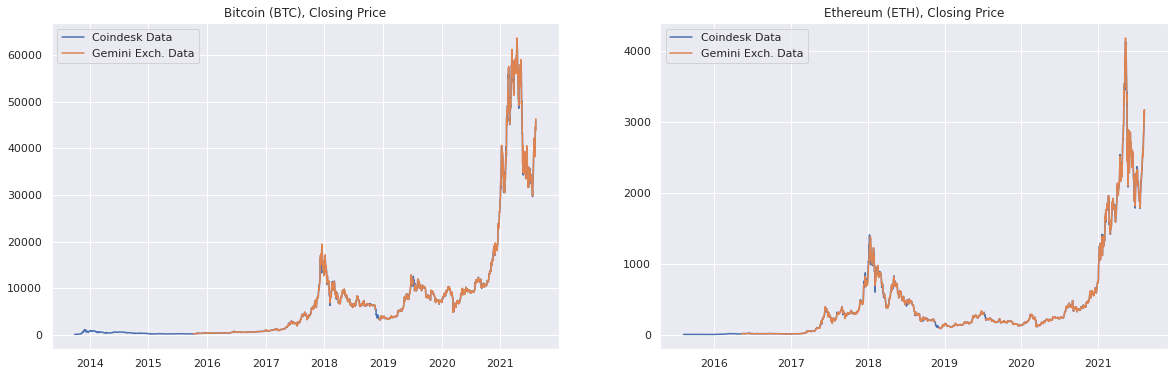

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(btc_daily['Closing Price (USD)'], label='Coindesk Data')
ax[0].plot(btc_m2d, label='Gemini Exch. Data')
ax[0].set_title('Bitcoin (BTC), Closing Price')
ax[0].legend(loc='upper left')

ax[1].plot(eth_daily['Closing Price (USD)'], label='Coindesk Data')
ax[1].plot(eth_m2d, label='Gemini Exch. Data')
ax[1].set_title('Ethereum (ETH), Closing Price')
ax[1].legend(loc='upper left')

plt.show()

While the Gemini data does have some missing values, the two series are very consistent. However, the Gemini data is missing prices for multiple days in November 2018.

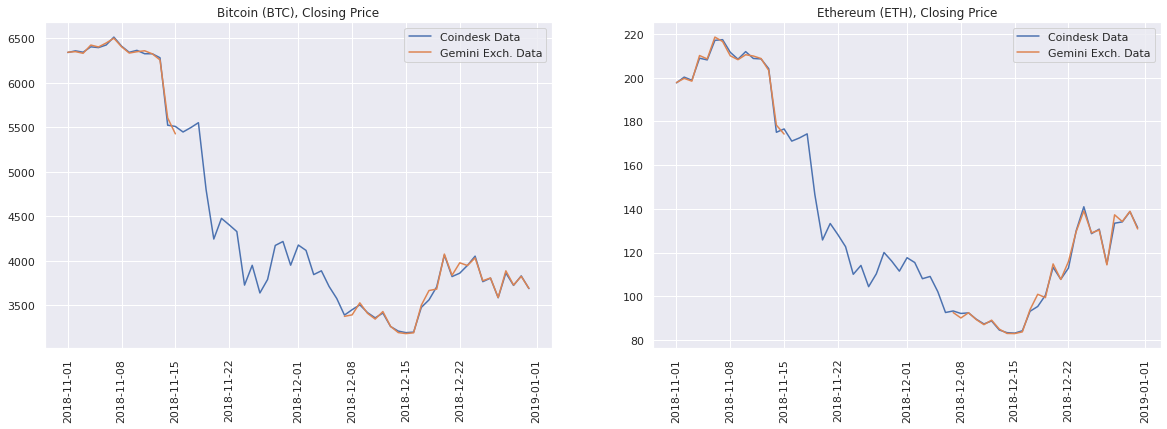

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(btc_daily.loc[(btc_daily.index >= '2018-11-01') & 
                         (btc_daily.index <= '2018-12-31'),
                         'Closing Price (USD)'], label='Coindesk Data')
ax[0].plot(btc_m2d.loc[(btc_m2d.index >= '2018-11-01') & 
                       (btc_m2d.index <= '2018-12-31')], label='Gemini Exch. Data')
ax[0].set_title('Bitcoin (BTC), Closing Price')
ax[0].legend(loc='upper right')

ax[1].plot(eth_daily.loc[(eth_daily.index >= '2018-11-01') & 
                         (eth_daily.index <= '2018-12-31'),
                         'Closing Price (USD)'], label='Coindesk Data')
ax[1].plot(eth_m2d.loc[(eth_m2d.index >= '2018-11-01') & 
                       (eth_m2d.index <= '2018-12-31')], label='Gemini Exch. Data')
ax[1].set_title('Ethereum (ETH), Closing Price')
ax[1].legend(loc='upper right')

for label in ax[0].get_xticklabels():
    label.set_rotation(90)

for label in ax[1].get_xticklabels():
    label.set_rotation(90)

plt.show()

In [16]:
print('Coindesk BTC Data: {:,}'.format(btc_daily['Closing Price (USD)'].isna().sum())
      + '/{:,} dates are missing price data'.format(btc_daily['Closing Price (USD)'].shape[0]))
print('Coindesk ETH Data: {:,}'.format(eth_daily['Closing Price (USD)'].isna().sum())
      + '/{:,} dates are missing price data'.format(eth_daily['Closing Price (USD)'].shape[0]))

print('Gemini BTC Data:   {:,}'.format(btc_m2d.isna().sum())
      + '/{:,} dates are missing price data'.format(btc_m2d.shape[0]))
print('Gemini ETH Data:   {:,}'.format(eth_m2d.isna().sum())
      + '/{:,} dates are missing price data'.format(eth_m2d.shape[0]))

Coindesk BTC Data: 0/2,871 dates are missing price data
Coindesk ETH Data: 0/2,194 dates are missing price data
Gemini BTC Data:   30/2,134 dates are missing price data
Gemini ETH Data:   30/1,920 dates are missing price data


The minute level data and daily data line up almost perfectly, so the Gemini minute level data should be a good source to calculate daily realized volatility. There are about 30 missing days, so we obtained minute level BTC data from Kaggle to fill in some of the missing values. First, we ensure that the Kaggle data is also consistent with the daily data from Coindesk.

In [17]:
btc_kaggle = pd.read_csv(os.path.join(DATA_DIR, 'Kaggle_BTC_minute_data.zip'))

btc_kaggle['Timestamp'] = pd.to_datetime(btc_kaggle['Timestamp'], unit='s')
btc_kaggle.set_index('Timestamp', drop=True, inplace=True)
btc_kaggle = btc_kaggle.resample('1T').asfreq()

btc_kaggle.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4863849 entries, 2011-12-31 07:52:00 to 2021-03-31 00:00:00
Freq: T
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Open               3613769 non-null  float64
 1   High               3613769 non-null  float64
 2   Low                3613769 non-null  float64
 3   Close              3613769 non-null  float64
 4   Volume_(BTC)       3613769 non-null  float64
 5   Volume_(Currency)  3613769 non-null  float64
 6   Weighted_Price     3613769 non-null  float64
dtypes: float64(7)
memory usage: 296.9 MB


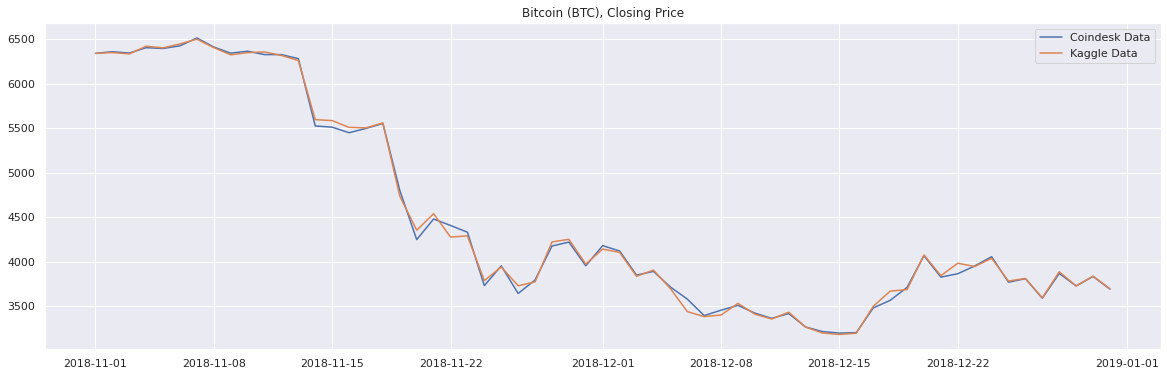

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

btc_kaggle_daily = btc_kaggle['Close'].resample('D').last()

ax.plot(btc_daily.loc[(btc_daily.index >= '2018-11-01') & 
                         (btc_daily.index <= '2018-12-31'),
                         'Closing Price (USD)'], 
           label='Coindesk Data')
ax.plot(btc_kaggle_daily.loc[(btc_kaggle_daily.index >= '2018-11-01') & 
                                (btc_kaggle_daily.index <= '2018-12-31')], 
           label='Kaggle Data')

ax.set_title('Bitcoin (BTC), Closing Price')
ax.legend(loc='upper right')

plt.show()

The two datasets appear to agree for the two month period around the November 2018 crash where we are missing Gemini data. Later, we'll use the Kaggle data to fill in missing values in our daily realized volatility calculated from the Gemini data. Before we do that, though, we explore some of the properties of BTC and ETH returns.

In [19]:
# calculate daily log returns for BTC and ETH
btc_price = btc_daily.loc[btc_daily.index >= '2015-12-31', 'Closing Price (USD)']
btc_ret = np.log(btc_price).diff()[1:]

eth_price = eth_daily.loc[eth_daily.index >= '2015-12-31', 'Closing Price (USD)']
eth_ret = np.log(eth_price).diff()[1:]

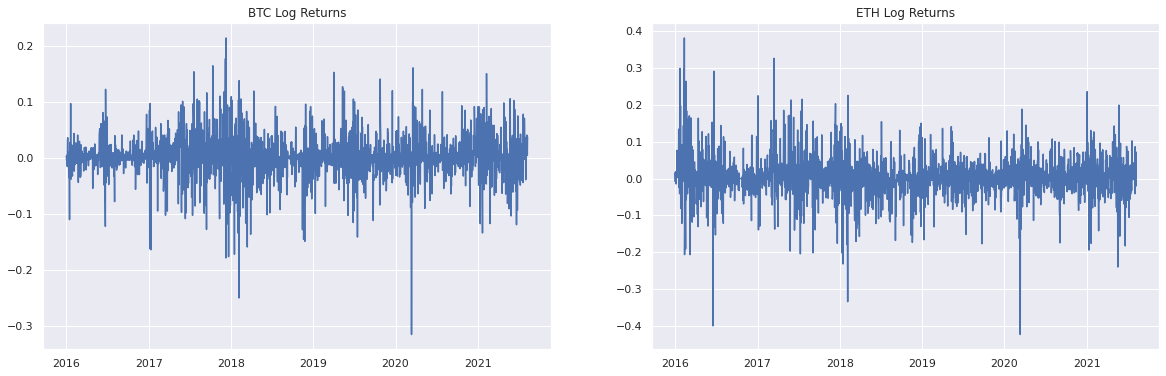

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(btc_ret)
ax[1].plot(eth_ret)

ax[0].set_title('BTC Log Returns')
ax[1].set_title('ETH Log Returns')

plt.show()

The two graphs above present the daily log return series for BTC and ETH. Returns exhibit a couple of notable characteristics:

1. Returns are generally centered around 0.
2. We see evidence of volatility clustering.

Equity returns also exhibit such characteristics; however, the magnitude of BTC and ETH returns is much larger than equity returns (in general), which is unsurprising given the growth of cryptocurrencies over the time period examined.

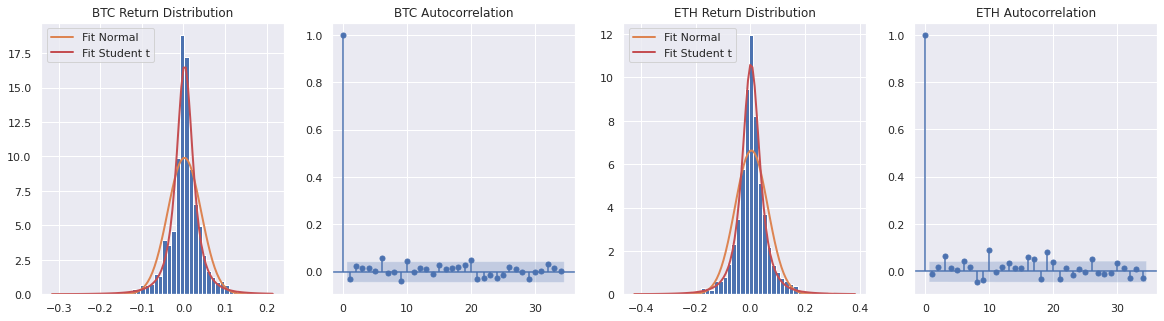

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# plot BTC graphs
ax[0].hist(btc_ret, bins=50, density=True)

x = np.linspace(btc_ret.min(), btc_ret.max(), 100)
ax[0].plot(x, stats.norm.pdf(x, *stats.norm.fit(btc_ret)), 
           label='Fit Normal', linewidth=2)
ax[0].plot(x, stats.t.pdf(x, *stats.t.fit(btc_ret)), 
           label='Fit Student t', linewidth=2, color='r')
ax[0].legend(loc='upper left')

plot_acf(btc_ret, ax=ax[1])

# plot ETH graphs
ax[2].hist(eth_ret, bins=50, density=True)

x = np.linspace(eth_ret.min(), eth_ret.max(), 100)
ax[2].plot(x, stats.norm.pdf(x, *stats.norm.fit(eth_ret)), 
           label='Fit Normal', linewidth=2)
ax[2].plot(x, stats.t.pdf(x, *stats.t.fit(eth_ret)), 
           label='Fit Student t', linewidth=2, color='r')
ax[2].legend(loc='upper left')

plot_acf(eth_ret, ax=ax[3])

ax[0].set_title('BTC Return Distribution')
ax[1].set_title('BTC Autocorrelation')
ax[2].set_title('ETH Return Distribution')
ax[3].set_title('ETH Autocorrelation')

plt.show()

Again, similar to equities (and many other financial instruments), returns have fatter tails than the normal distribution, and the Student t-distribution appears to be a much better fit. Returns also do not exhibit significant autocorrelation.

In [22]:
print('BTC')
print('Skew:            {:.4f}'.format(stats.skew(btc_ret)))
print('Kurtosis: {:.4f}'.format(stats.kurtosis(btc_ret)))

print('\nETH')
print('Skew:            {:.4f}'.format(stats.skew(eth_ret)))
print('Kurtosis: {:.4f}'.format(stats.kurtosis(eth_ret)))

BTC
Skew:            -0.4753
Kurtosis: 5.3738

ETH
Skew:            -0.0086
Kurtosis: 5.9682


Interestingly, while ETH returns have very little skew, BTC returns are negatively skewed.

In [23]:
# calculate daily volume from the Gemini data
btc_volume = btc_min.loc[btc_min.index >= '2016-01-01', 'Volume'].resample('D').sum()
eth_volume = eth_min.loc[eth_min.index >= '2016-01-01', 'Volume'].resample('D').sum()

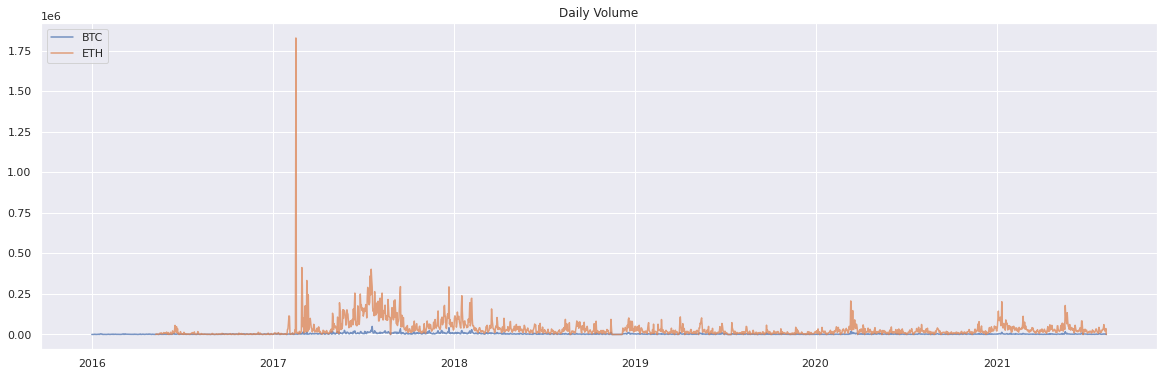

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(btc_volume, label='BTC', alpha=0.75)
ax.plot(eth_volume, label='ETH', alpha=0.75)

ax.set_title('Daily Volume')
ax.legend(loc='upper left')

plt.show()

Volume looks pretty strange. However, this is only volume on the Gemini exchange and we don't use volume in any subsequent analyses, so we'll move on.

Next, we calculate daily realized volatility. We use both the traditional realized variance estimator:
$$
\hat{\sigma}^2_{RV} = \sum_{i=1}^{n} (X(t_{i + 1} - X(t_i))^2
$$
were $X_t$ is the log price at time $t$, and the two scale realized volatility (TSRV) estimator proposed by Zhang, Ait-Sahalia, and Mykland (2005) (see report for full citation):
$$
\hat{\sigma}^2_{TSRV} = \bigl( 1 - \frac{z}{n} \bigl)^{-1} \bigg( [X, X]^{Avg} - \frac{z}{n} [X, X]^{All} \bigg) \\
[X, X]^{Avg} = \frac{1}{K} \sum_{i=1}^{n - K + 1} (X(t_{i + K} - X(t_i))^2, \hspace{0.75cm} [X, X]^{Avg} = \sum_{i=1}^{n} (X(t_{i + 1} - X(t_i))^2 \\
z = \frac{n - K + 1}{K} \\
$$
We use 1 minute returns for $\hat{\sigma}^2_{RV}$ and 1 minute returns plus 5 minute returns, $K=5$, for $\hat{\sigma}^2_{TSRV}$. Daily volatility is then the square root of the realized variance estimators.

In [25]:
def realized_vol(prices, sample_freq='1T', min_count=720):
    """
    Calculate realized volatility using high frequency (minute level
    in this case) data.

    min_count controls the minimum number of data points (i.e., minutes of data) 
    in a day that are required to calculate the realized variance for the day
    e.g., min_count=720 means 720/1440 minutes of data must be non-null for 
    the realized variance to be calculated; if there is less than 720 minutes 
    of data, the value for the day is set as np.nan
    """
    x = np.log(prices.resample(sample_freq).last())
    realized_var = (x.diff(1)[1:] ** 2).resample('D').sum(min_count=min_count)

    return np.sqrt(realized_var)

def tsrv(prices, k, sample_freq='1T', min_count=720):
    """
    Calculate the Two Scale Realized Volatility (TSRV) estimator 
    proposed by Zhang, Ait-Sahalia, and Mykland (2005)
    """
    x = np.log(prices.resample(sample_freq).last())

    rv_all = (x.diff(1)[1:] ** 2).resample('D').sum(min_count=min_count)
    rv_avg = (1 / k) * (x.diff(k)[k:] ** 2).resample('D').sum()
    
    n = len(x)
    z = (n - k + 1) / k

    tsrv = (1 - z / n) ** -1 * (rv_avg - (z / n) * rv_all)

    return np.sqrt(tsrv)

In [26]:
# calculate daily realized volatility
btc_rv = realized_vol(btc_min.loc[btc_min.index >= '2016-01-01', 'Close'], 
                      sample_freq='1T', min_count=720)
eth_rv = realized_vol(eth_min.loc[eth_min.index >= '2016-01-01', 'Close'], 
                      sample_freq='1T', min_count=720)

# calculate TSRV
btc_tsrv = tsrv(btc_min.loc[btc_min.index >= '2016-01-01', 'Close'], 5, 
                sample_freq='5T', min_count=144)
eth_tsrv = tsrv(eth_min.loc[eth_min.index >= '2016-01-01', 'Close'], 5, 
                sample_freq='5T', min_count=144)

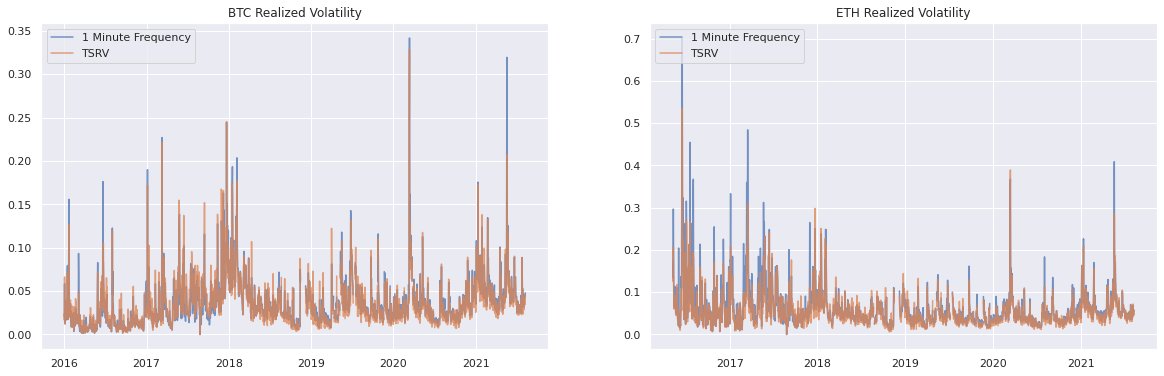

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(btc_rv, label='1 Minute Frequency', alpha=0.75)
ax[1].plot(eth_rv, label='1 Minute Frequency', alpha=0.75)

ax[0].plot(btc_tsrv, label='TSRV', alpha=0.75)
ax[1].plot(eth_tsrv, label='TSRV', alpha=0.75)

ax[0].set_title('BTC Realized Volatility')
ax[1].set_title('ETH Realized Volatility')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

plt.show()

Overall, the two realized volatility estimates are quite similar. The TSRV estimator adjusts for microstructure noise, though, so it generally provides a lower estimate. We can see that the TSRV estimator has lower spikes in volatility (note the blue "tips" when volatility spikes). We use the TSRV estimator going forward.

In [28]:
print('Realized Volatility')
print('BTC: {:,}'.format(btc_rv.isna().sum())
      + '/{:,} dates are missing realized vol'.format(btc_rv.shape[0]))
print('ETH: {:,}'.format(eth_rv.isna().sum())
      + '/{:,} dates are missing realized vol'.format(eth_rv.shape[0]))

print('\nTSRV')
print('BTC: {:,}'.format(btc_tsrv.isna().sum())
      + '/{:,} dates are missing realized vol'.format(btc_tsrv.shape[0]))
print('ETH: {:,}'.format(eth_tsrv.isna().sum())
      + '/{:,} dates are missing realized vol'.format(eth_tsrv.shape[0]))

Realized Volatility
BTC: 74/2,049 dates are missing realized vol
ETH: 75/1,920 dates are missing realized vol

TSRV
BTC: 74/2,049 dates are missing realized vol
ETH: 75/1,920 dates are missing realized vol


We have quite a few days with missing realized volatility estimates, though, so we'll try to fill these in next.

In [29]:
# calculate TSRV with the Kaggle BTC data
btc_tsrv_kaggle = tsrv(btc_kaggle.loc[btc_kaggle.index >= '2016-01-01', 'Close'], 
                       5, sample_freq='5T', min_count=144)

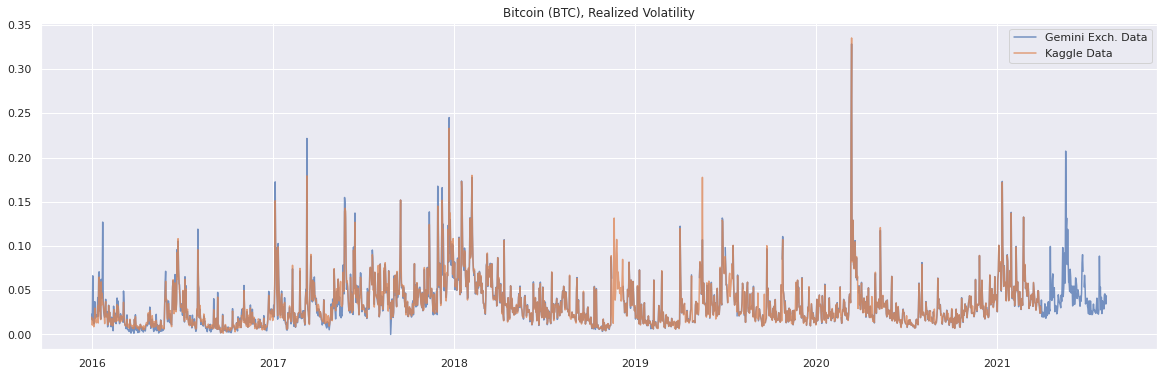

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(btc_tsrv, label='Gemini Exch. Data', alpha=0.75)
ax.plot(btc_tsrv_kaggle, label='Kaggle Data', alpha=0.75)

ax.set_title('Bitcoin (BTC), Realized Volatility')
ax.legend(loc='upper right')

plt.show()

The two series are quite consistent. The Gemini data appears to have higher spikes in volatility than the Kaggle data, but the Kaggle data includes some of the missing days from the Gemini data. We use the Kaggle TSRV to fill in the Gemini TSRV, which we use as our main source for volatility.

In [31]:
# fill in missing values where possible
na_dates = btc_tsrv[btc_tsrv.isna()].index
fill_values = btc_tsrv_kaggle[btc_tsrv_kaggle.index.isin(na_dates)]

btc_tsrv[fill_values.index] = fill_values.values

print('\nTSRV')
print('BTC: {:,}'.format(btc_tsrv.isna().sum())
      + '/{:,} dates are missing realized vol'.format(btc_rv.shape[0]))


TSRV
BTC: 2/2,049 dates are missing realized vol


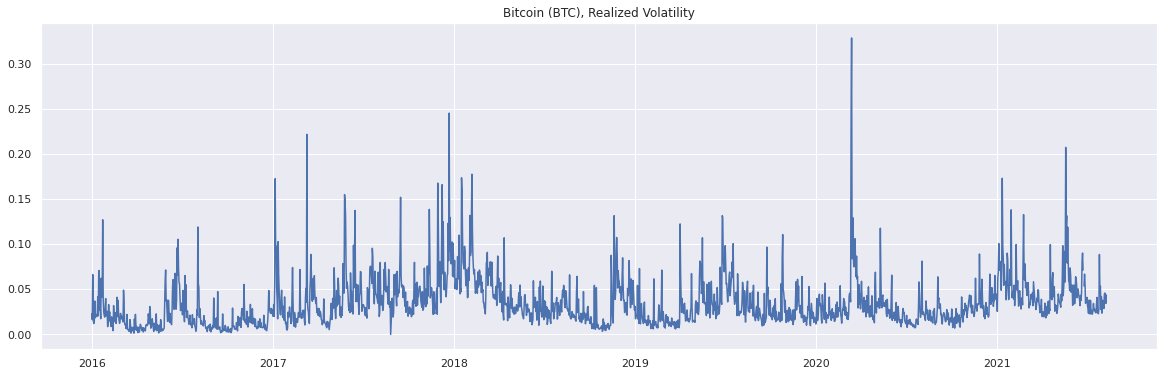

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(btc_tsrv)
ax.set_title('Bitcoin (BTC), Realized Volatility')

plt.show()

We still have 2 days with missing BTC realized volatility estimates, and we do not have additional minute level data for ETH, so we look into interpolation options next.

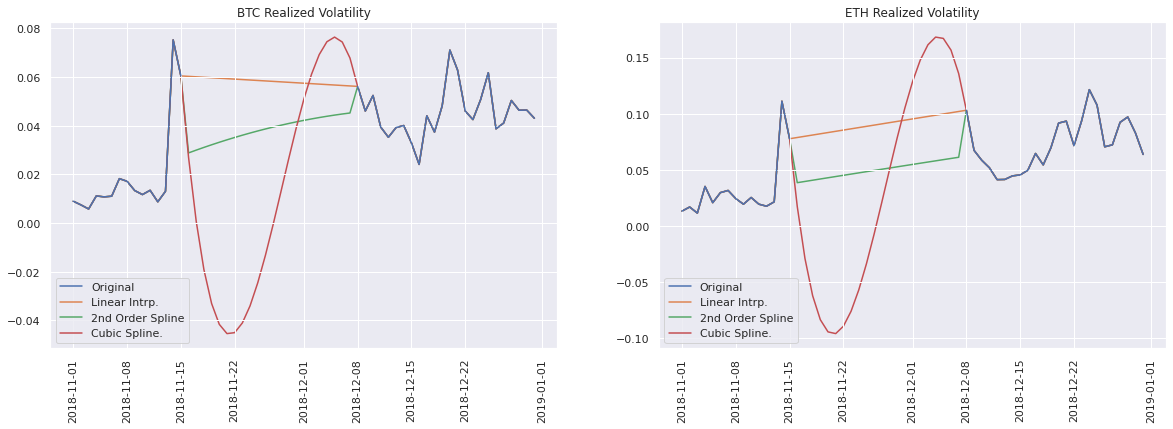

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

btc_subset = btc_rv.loc[(btc_rv.index >= '2018-11-01') & 
                        (btc_rv.index <= '2018-12-31')]
eth_subset = eth_rv.loc[(eth_rv.index >= '2018-11-01') & 
                        (eth_rv.index <= '2018-12-31')]

ax[0].plot(btc_subset, label='Original', zorder=1)
ax[0].plot(btc_subset.interpolate(method='linear'), label='Linear Intrp.', zorder=0)
ax[0].plot(btc_subset.interpolate(method='spline', order=2), label='2nd Order Spline', zorder=0)
ax[0].plot(btc_subset.interpolate(method='cubicspline'), label='Cubic Spline.', zorder=0)
ax[0].legend(loc='lower left')

ax[1].plot(eth_subset, label='Original', zorder=1)
ax[1].plot(eth_subset.interpolate(method='linear'), label='Linear Intrp.', zorder=0)
ax[1].plot(eth_subset.interpolate(method='spline', order=2), label='2nd Order Spline', zorder=0)
ax[1].plot(eth_subset.interpolate(method='cubicspline'), label='Cubic Spline.', zorder=0)
ax[1].legend(loc='lower left')

ax[0].set_title('BTC Realized Volatility')
ax[1].set_title('ETH Realized Volatility')

for label in ax[0].get_xticklabels():
    label.set_rotation(90)

for label in ax[1].get_xticklabels():
    label.set_rotation(90)

plt.show()

The graphs above explore three options for interpolating missing values. November 2018 is actually a period of relatively high volatility for both BTC and ETH, and we see prices fall approximately 35% over the period where we have missing data. As such, we decide to use simple linear interpolation for missing data points as it more accurately captures the level of volatility during this period. Note that this is only an issue for the ETH data.

Realized volatility is usually highly persistent, so we examinte the autocorrelation for the series next.

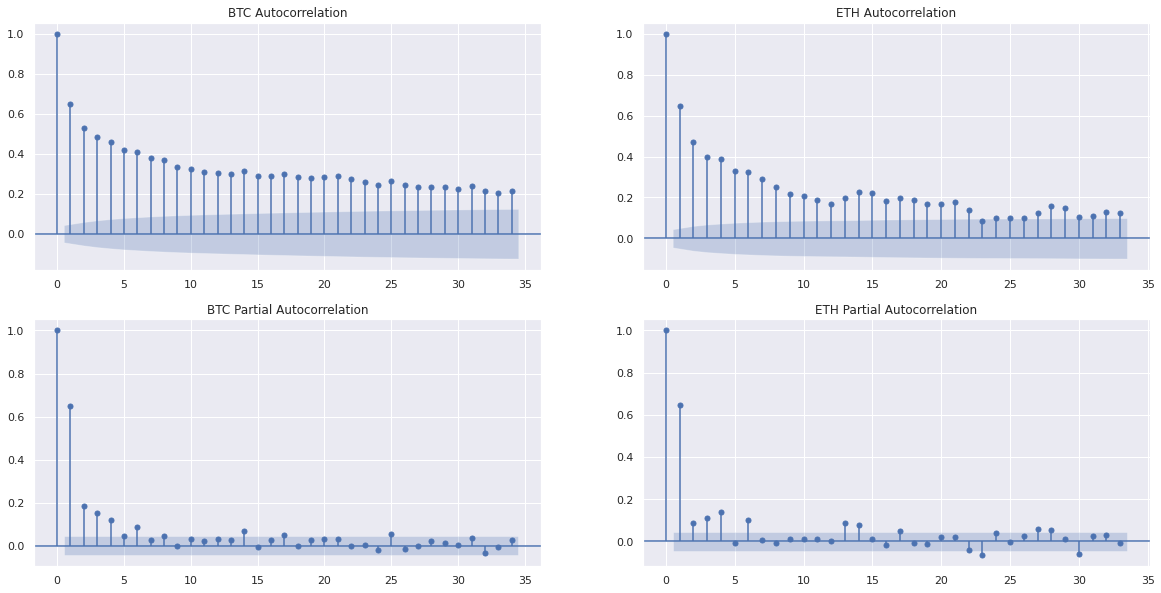

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plot_acf(btc_tsrv.interpolate(method='linear'), ax=ax[0][0])
plot_acf(eth_rv.interpolate(method='linear')[1:], ax=ax[0][1])  # first value is np.nan, so we remove it

plot_pacf(btc_tsrv.interpolate(method='linear'), ax=ax[1][0])
plot_pacf(eth_rv.interpolate(method='linear')[1:], ax=ax[1][1])  # first value is np.nan, so we remove it

ax[0][0].set_title('BTC Autocorrelation')
ax[0][1].set_title('ETH Autocorrelation')

ax[1][0].set_title('BTC Partial Autocorrelation')
ax[1][1].set_title('ETH Partial Autocorrelation')

plt.show()

No surprises in the ACF/PACF plots. So far our realized volatility estimates look quite reasonable! 

Next, we use the daily return data to estimate conditional volatility using a GARCH model. We find that GARCH(1, 1) with t-distribution innovations fits the data well. Interestingly, we did not find a significant asymmetric response in variance when using the GJR-GARCH model, so we exlude the asymmetry term in the model used below. 

In [35]:
btc_garch = arch_model(btc_ret * 100, p=1, o=0, q=1, dist='t')
btc_res = btc_garch.fit()
print(btc_res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 39854.191871739764
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12017.808100715672
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8430.646701784537
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6940.142324723074
Iteration:      5,   Func. Count:     38,   Neg. LLF: 6792.977803500407
Iteration:      6,   Func. Count:     45,   Neg. LLF: 5329.4629150174205
Iteration:      7,   Func. Count:     52,   Neg. LLF: 5309.4424679233325
Iteration:      8,   Func. Count:     58,   Neg. LLF: 6505.201235721334
Iteration:      9,   Func. Count:     65,   Neg. LLF: 5352.371345931198
Iteration:     10,   Func. Count:     73,   Neg. LLF: 5303.406841332406
Iteration:     11,   Func. Count:     79,   Neg. LLF: 5302.720001380054
Iteration:     12,   Func. Count:     85,   Neg. LLF: 5302.52180942045
Iteration:     13,   Func. Count:     91,   Neg. LLF: 5302.447918544878
Iteration:     14,   Func. Count:     97,   Neg. LLF: 5302.43

In [36]:
eth_garch = arch_model(eth_ret * 100, p=1, o=0, q=1, dist='t')
eth_res = eth_garch.fit()
print(eth_res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 47581.63085514021
Iteration:      2,   Func. Count:     15,   Neg. LLF: 37949.64655788767
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7980.977883984255
Iteration:      4,   Func. Count:     30,   Neg. LLF: 7858.260966971515
Iteration:      5,   Func. Count:     37,   Neg. LLF: 7653.405782166019
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7584.013402836603
Iteration:      7,   Func. Count:     51,   Neg. LLF: 7551.457321290657
Iteration:      8,   Func. Count:     58,   Neg. LLF: 6190.326867813665
Iteration:      9,   Func. Count:     65,   Neg. LLF: 6182.05485084672
Iteration:     10,   Func. Count:     71,   Neg. LLF: 7384.274099824775
Iteration:     11,   Func. Count:     78,   Neg. LLF: 6181.7196137992405
Iteration:     12,   Func. Count:     85,   Neg. LLF: 6180.090260083203
Iteration:     13,   Func. Count:     91,   Neg. LLF: 6180.077640925409
Iteration:     14,   Func. Count:     97,   Neg. LLF: 6180.07247

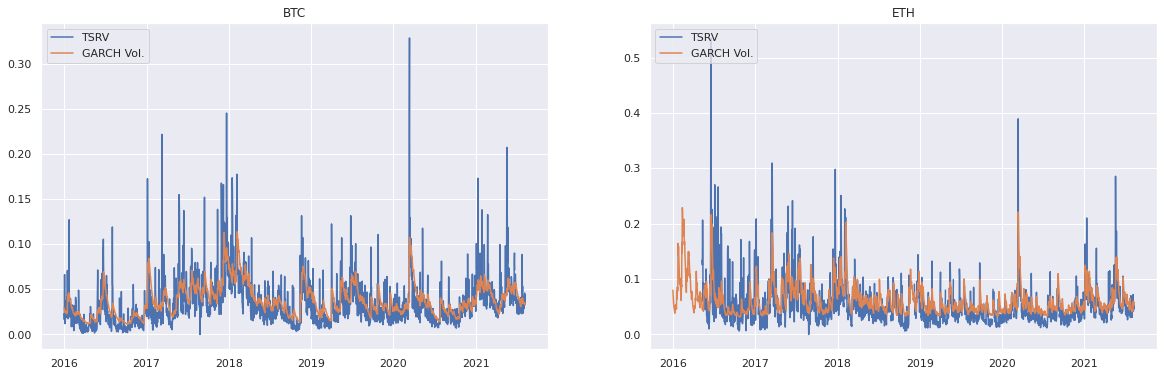

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(btc_tsrv, label='TSRV')
ax[0].plot(btc_res.conditional_volatility / 100, 
           label='GARCH Vol.')
ax[0].legend(loc='upper left')

ax[1].plot(eth_tsrv, label='TSRV')
ax[1].plot(eth_res.conditional_volatility / 100,
           label='GARCH Vol.')
ax[1].legend(loc='upper left')

ax[0].set_title('BTC')
ax[1].set_title('ETH')

plt.show()

The realized and conditional volatility estimates are directionally consistent, as we would expect. The realized volatility is itself more volatile than the conditional volatility, but this is also a common distinction between the two estimates. The true underlying volatility is unobservable, and both the conditional volatility from the GARCH model and the realized volatility estimated on high frequency data just provide estimates of the true value. We elect to use realized volatility from the minute level data for our analyses as it allows us to directly model the volatility using standard regression/autoregressive models.

Finally, we compile the daily price, return, and volatility data into a single DataFrame to save.

In [38]:
data = pd.DataFrame({
    'BTC Price': btc_price,
    'BTC Return': btc_ret,
    'BTC Realized Vol': btc_tsrv,
    'ETH Price': eth_price,
    'ETH Return': eth_ret,
    'ETH Realized Vol': eth_tsrv
})

data = data.loc[(data.index >= '2016-01-01') & (data.index <= '2021-07-31'), :]
data = data.resample('D').asfreq()
data.head(10)

,BTC Price,BTC Return,BTC Realized Vol,ETH Price,ETH Return,ETH Realized Vol
Date,,,,,,
2016-01-01,433.773,0.003267,0.022992,0.954338,0.015177,NaN
2016-01-02,431.985,-0.004130,0.016493,0.946475,-0.008273,NaN
2016-01-03,431.691,-0.000681,0.066332,0.964273,0.018630,NaN
2016-01-04,433.732,0.004717,0.015479,0.959200,-0.005275,NaN
2016-01-05,427.164,-0.015259,0.012086,0.945187,-0.014717,NaN
2016-01-06,441.021,0.031924,0.013905,0.954133,0.009420,NaN
2016-01-07,457.168,0.035958,0.037113,0.971532,0.018071,NaN
2016-01-08,452.368,-0.010555,0.018515,0.973215,0.001731,NaN
2016-01-09,445.327,-0.015687,0.020749,0.976544,0.003415,NaN


In [39]:
data.tail(10)

,BTC Price,BTC Return,BTC Realized Vol,ETH Price,ETH Return,ETH Realized Vol
Date,,,,,,
2021-07-22,32203.365638,0.005884,0.024905,2005.726461,0.018748,0.042747
2021-07-23,33117.751462,0.027998,0.024045,2079.950552,0.036338,0.036933
2021-07-24,34014.618359,0.026721,0.022975,2167.821498,0.041379,0.030797
2021-07-25,34574.670661,0.016331,0.028275,2161.052224,-0.003128,0.035446
2021-07-26,37114.296624,0.070881,0.088621,2225.740338,0.029494,0.070002
2021-07-27,38963.922857,0.048634,0.047000,2300.611383,0.033085,0.056519
2021-07-28,39917.449369,0.024177,0.053399,2303.377934,0.001202,0.044658
2021-07-29,39810.517971,-0.002682,0.027797,2332.169274,0.012422,0.033785
2021-07-30,41157.154833,0.033267,0.042037,2435.498682,0.043353,0.041743


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Freq: D
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BTC Price         2039 non-null   float64
 1   BTC Return        2039 non-null   float64
 2   BTC Realized Vol  2038 non-null   float64
 3   ETH Price         2039 non-null   float64
 4   ETH Return        2039 non-null   float64
 5   ETH Realized Vol  1836 non-null   float64
dtypes: float64(6)
memory usage: 111.5 KB


In [41]:
data.to_csv(os.path.join(DATA_DIR, 'price_return_vol_data.csv'))